#### **Overall Plan:**
The Pawpularity problem asks to build a model to score cuteness of image of a pet. Since it is a score, I will be solving this problem as a Regression task.

**Features:**
There are two inputs: a) the images and b) the metadata of the images. I plan to use both the information in my modeling as described below.

**Model:**
I plan to use three class of models:
- Deep Learning model
- Linear model
- Ensemble model

**Usage of the features and Model:**
I will be using the models and features and described below.

- **Deep Learning:** The data has images. A deep learning model designed to work on images is Convolution Neural Network (CNN). I am using an advanced variant of the CNN called the Residual Network (ResNet). I picked up a pre-trained ResNet-50 model which was trained on imagenet data. I further fine-tuned the ResNet-50 model on the images with an objective to minimize the squared error between the prediction and the pawpularity score.
Now I plan to use the fine-tuned model in two ways:     
  - Use the fine-tuned model for prediction. 
  - Use the fine-tuned model as feature extractor: I plan to use the features of the images from the last layer which goes to the output unit. I believe the layer will have a dense representation of the features of the image. This image feature will be further used by the linear and ensemble models.

- **Linear Model:** I am using two linear models: Ridge Regression and Lasso Regression. I tried these models with only the metadata and with the metadata and the image features (extracted from the Deep Learning model). I tried different hyperparameters and evaluated them using 5-fold cross validation.

- **Ensemble Model:** I am using three ensemble models: Random Forest Regressor, Adaboost Regressor, and Stacking Regressor. I tried these models with only the metadata and with the metadata and the image features (extracted from the Deep Learning model). I tried different hyperparameters and evaluated them using 5-fold cross validation. For stacking, I used the Ridge Regressor (linear), Support Vector Regressor (non-linear), and the Random Forest (ensemble) as base estimators and the Linear Regression as the final estimator.



#### **Validation Scheme**

To get an unbiased estimate of the test score which kaggle would assign:
- **For Deep Learning Model:** I splitted the data into Train-Validate-Test (81%-10%-9%) set. The model was trained on the train set and its performance was measured on the validation set. The validation set was used for early stopping and check-pointing the best model. The fitted model was then evaluated on the test set.

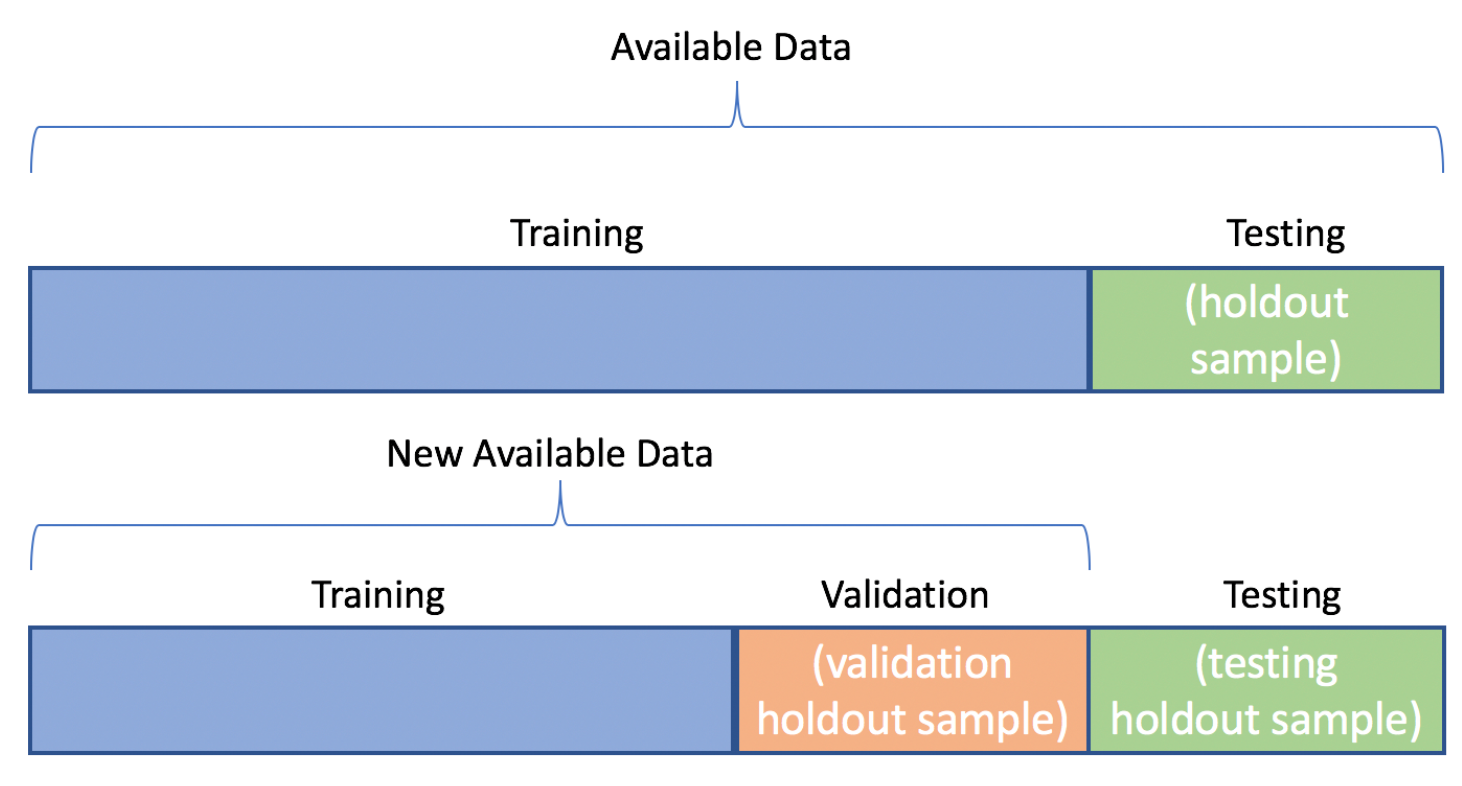

- **For Linear and Ensemble (Random Forest, Adaboost) Model:** I splitted the data into Train and Test set. The train set was cross-validated using 5-fold cross validation. The cross validation was used to evaluate the performance of the model for different hyperparameters. The model which performed the best (lowest RMSE on the validation set) was then used to report its score on the test set.
- **For Stacking model:** I splitted the data into Train and Test set. The base estimators were fiited on the training data using 5-fold cross-validation. Each estimator's prediction in cross-validation was used as input to the fianl estimator and it was fitted on the data. The performance of the final estimator in then reported on the test set.

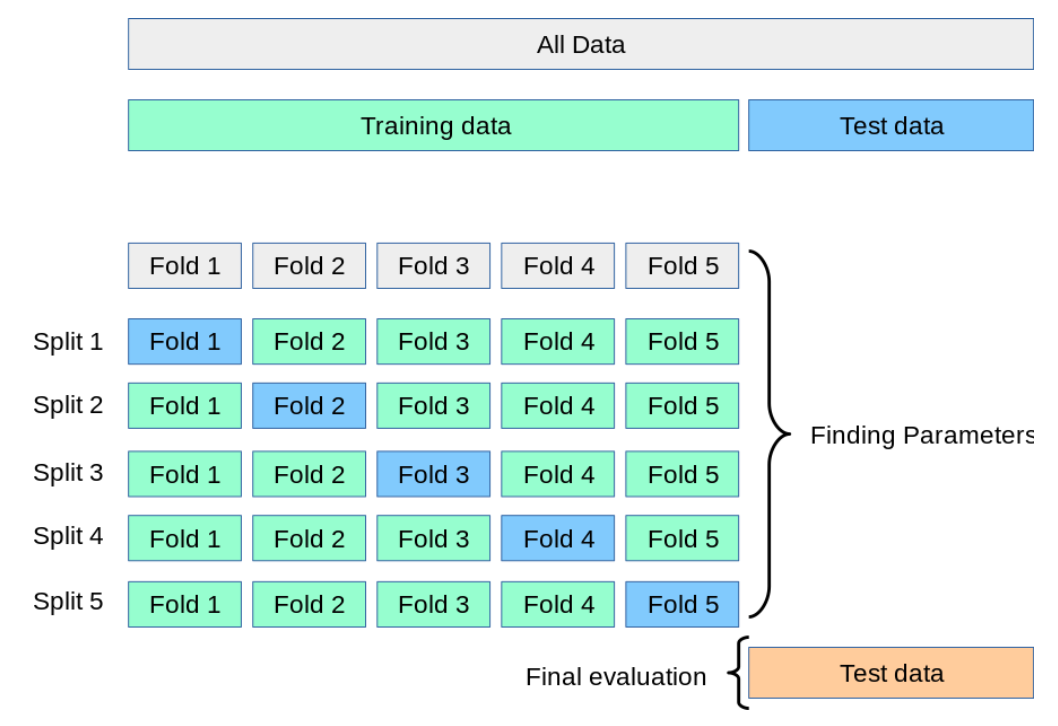


#### **Input Preprocessing**

**Image Input:** The image input is sent to the ResNet model to get image features. The preprocessing done is as follows:
- The input image is resized to the 224 \* 224 in all channels to meet the size of the pretrained ResNet-50 model, which is trained on imagenet accepting the size of 224 \* 224.
- The order of the channel is changed from RGB to BGR, this is done for compatibility with pretrained ResNet-50 model.
- Each color channel in the input is zero-centered, with respect to the ImageNet dataset.
- However, the input is not scaled.

**Metadata:** I am using the meta-data in some models. However, there is no pre-processing done in the meta-data other than removing the Id column, which stores the image file name.



#### **Setup**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/589/Project/')

%cd '/content/drive/MyDrive/589/Project/'
%pwd

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1TXnZvYXU1BNwOSDbNVfaOVsA93pnAdAp/Project


'/content/drive/.shortcut-targets-by-id/1TXnZvYXU1BNwOSDbNVfaOVsA93pnAdAp/Project'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Model
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.losses import MeanAbsolutePercentageError
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import History

import warnings
warnings.filterwarnings('ignore')

#### **Splitting the data to Train-Validate-Test**

In [3]:
def split_data(df):
    
    train, val = train_test_split(df, test_size=0.1, random_state=589)
    
    train, test = train_test_split(
        train, test_size=0.1, random_state=589
    )

    print("shape train: ", train.shape)
    print("shape val: ", val.shape)
    print("shape test: ", test.shape)

    return train, val, test

def create_generators(df, dir, train, val, test):
    
    train_generator = ImageDataGenerator()
    
    validation_generator = ImageDataGenerator()
    
    test_generator = ImageDataGenerator()
    
    train_generator = train_generator.flow_from_dataframe(
        dataframe=train,
        directory=dir,
        x_col="image_filename",
        y_col="Pawpularity",
        class_mode="raw",
        target_size=(224, 224),
        batch_size=32,
    )

    validation_generator = validation_generator.flow_from_dataframe(
        dataframe=val,
        directory=dir,
        x_col="image_filename",
        y_col="Pawpularity",
        class_mode="raw",
        target_size=(224, 224),
        batch_size=32,
    )

    test_generator = test_generator.flow_from_dataframe(
        dataframe=test,
        directory=dir,
        x_col="image_filename",
        y_col="Pawpularity",
        class_mode="raw",
        target_size=(224, 224),
        batch_size=32,
    )
    
    return train_generator, validation_generator, test_generator

In [30]:
PATH = os.path.join('petfinder-pawpularity-score')
TRAIN_PATH = os.path.join(PATH, 'train')
train_metadata = pd.read_csv(PATH + '/train.csv')
train_metadata['image_filename'] = train_metadata['Id'] + '.jpg'

train, val, test = split_data(train_metadata)

train_generator, validation_generator, test_generator = create_generators(
    train_metadata,
    TRAIN_PATH,
    train,
    val,
    test)

shape train:  (8028, 15)
shape val:  (992, 15)
shape test:  (892, 15)
Found 8028 validated image filenames.
Found 992 validated image filenames.
Found 892 validated image filenames.


#### **Visualize Data and Basic EDA**

I first visualized images in different bucket of scores (bucket of size 10). This helped me in identifying what distinguishes an image of score say 100 with an image of score say 50 or 10. 

There are visible differences in terms of image collage, clarity of the face, posture of the pet, certain facial expressions and structures. These characteristic is what I am assuming the Deep Learning model will be able to identify and represent.

To understand the significance of meta-data, I first plotted a correlation map between the features and the output. I found that there is no significant correlation between any particular feature and the output. However, the information seems to be useful. So I will use the metadata in the models.

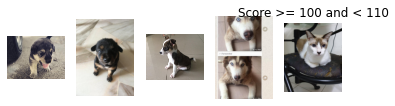

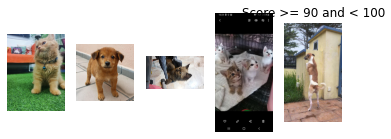

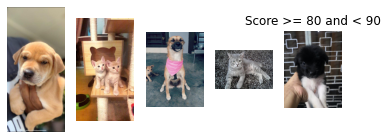

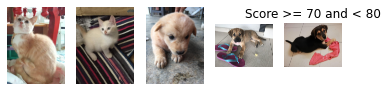

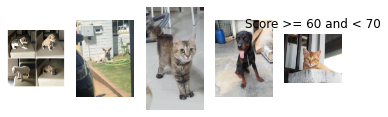

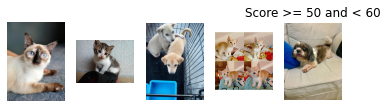

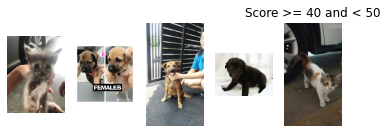

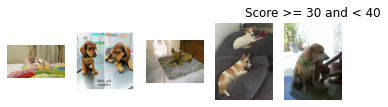

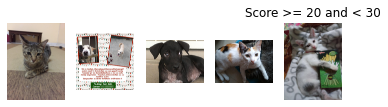

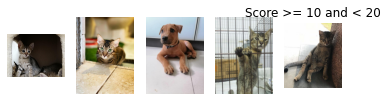

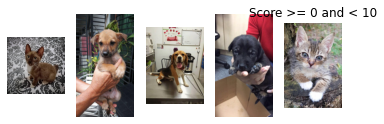

In [34]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for pawpularity in [100, 90, 80, 70, 60, 50, 40, 30, 20, 10, 0]:

  images = (TRAIN_PATH + '/' + train[ (train['Pawpularity'] >= pawpularity) & \
           (train['Pawpularity'] < pawpularity + 10) ]['Id'] + '.jpg').head(5)

  for i, x in enumerate(images):
    img = mpimg.imread(x)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
  
  plt.title(f'Score >= {pawpularity} and < {pawpularity + 10}')
  plt.show()

In [7]:
import seaborn as sb

sb.set(rc = {'figure.figsize':(15,10)})

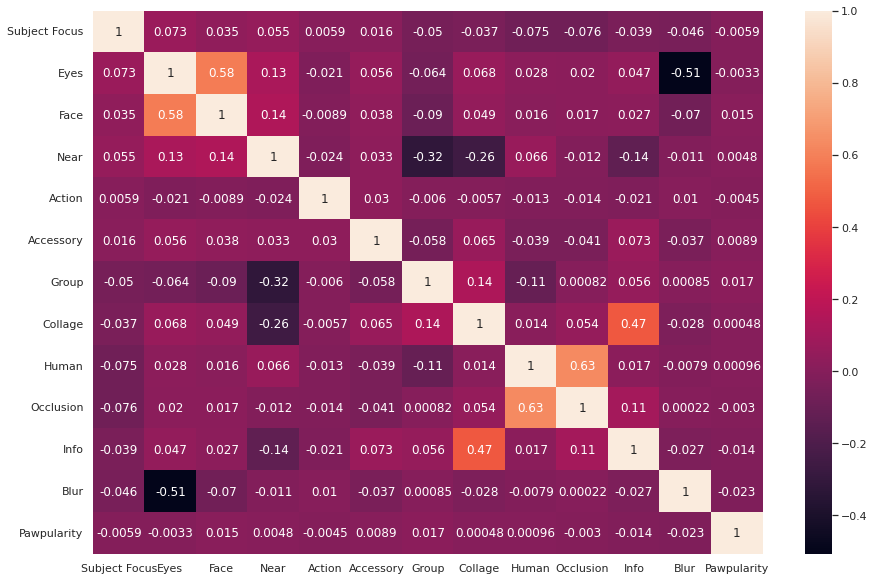

In [8]:
# plotting correlation heatmap
dataplot = sb.heatmap(train.corr(), annot=True)
  
# displaying heatmap
plt.show()

#### **Deep Learning**

For Deep Learning I used ResNet-50 model. The primary choice of neural network for images is the Convolution Neural Network. The model allows local shared connections which can represent local to hierarchically global features in the iamges. It has been demonstrated that deeper Convolution Neural Networks perform better than shallower network. However, deeper neural networks are more difficult to train. ResNet present a residual learning framework to ease the training of networks that are substantially deeper than those used previously. It explicitly reformulate the layers as learning residual functions with reference to the layer inputs, instead of learning unreferenced functions. I selected a 50 layer deep ResNet, i.e. ResNet-50.

I selected a ResNet-50 model which was pretrained on ImageNet data and fine-tuned it with a regression head to predict the Pet Score.

**Image Preprocessing**
- The input image is resized to the 224 \* 224 in all channels to meet the size of the pretrained ResNet-50 model, which is trained on imagenet accepting the size of 224 \* 224.
- The order of the channel is changed from RGB to BGR, this is done for compatibility with pretrained ResNet-50 model.
- Each color channel in the input is zero-centered, with respect to the ImageNet dataset.
- However, the input is not scaled.

**I fitted the model with**
- Loss: Mean Squared Error
- Max Epoch: 20
- Batch Size: 32
- Optimizer: Adam 
- Metric: Root Mean Squared Error
- Early stopping: Keeping an eye on the validation RMSE with a patience of 5
- Saving best model checkpoint: Save the model with the best validation RMSE and use that.

**Result on held-out test set: 20.297**

In [32]:
def preprocess_image_input(input_images):
  input_images = tf.cast(input_images, 'float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims


class Preprocess(tf.keras.layers.Layer):
    def __init__(self):
        super(Preprocess, self).__init__()

    def call(self, inputs):
        return preprocess_image_input(inputs)


def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.resnet.ResNet50(
                                               input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor


def feature_image_extractor(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    return x


def final_model(input):
    pre_process = Preprocess()(input)
    resnet_feature_extractor = feature_extractor(pre_process)
    features_img = feature_image_extractor(resnet_feature_extractor)
    x = tf.keras.layers.Dense(1, activation="linear")(features_img)
    return x


def define_compile_model():
  inputsImg = tf.keras.layers.Input(shape=(224,224,3))
  reg_output = final_model(inputsImg) 
  model = tf.keras.Model(inputs=inputsImg, outputs=reg_output)
  model.compile(optimizer='Adam', 
                loss=tf.keras.losses.MeanSquaredError(),
                metrics = [tf.keras.metrics.RootMeanSquaredError()])
  return model


model = define_compile_model()

model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 preprocess (Preprocess)     (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176

In [14]:
total_epochs =  20

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
                                monitor='val_root_mean_squared_error', 
                                patience=5,
                                mode='min')

checkpoint_filepath = 'checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_root_mean_squared_error',
    mode='min',
    save_best_only=True)

history = model.fit(
    train_generator,
    epochs=total_epochs,
    validation_data=validation_generator,
    batch_size=32,
    callbacks=[early_stopping_callback, model_checkpoint_callback]
    )

Epoch 1/20
251/251 [==============================] - ETA: 0s - loss: 487.6534 - root_mean_squared_error: 22.0829INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


251/251 [==============================] - 1691s 7s/step - loss: 487.6534 - root_mean_squared_error: 22.0829 - val_loss: 1395.3899 - val_root_mean_squared_error: 37.3549
Epoch 2/20
251/251 [==============================] - ETA: 0s - loss: 453.9655 - root_mean_squared_error: 21.3065INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


251/251 [==============================] - 164s 652ms/step - loss: 453.9655 - root_mean_squared_error: 21.3065 - val_loss: 402.4925 - val_root_mean_squared_error: 20.0622
Epoch 3/20
251/251 [==============================] - 124s 492ms/step - loss: 452.3478 - root_mean_squared_error: 21.2685 - val_loss: 532.8768 - val_root_mean_squared_error: 23.0841
Epoch 4/20
251/251 [==============================] - 122s 484ms/step - loss: 441.3197 - root_mean_squared_error: 21.0076 - val_loss: 407.0679 - val_root_mean_squared_error: 20.1759
Epoch 5/20
251/251 [==============================] - ETA: 0s - loss: 444.2203 - root_mean_squared_error: 21.0765INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


251/251 [==============================] - 154s 614ms/step - loss: 444.2203 - root_mean_squared_error: 21.0765 - val_loss: 389.1482 - val_root_mean_squared_error: 19.7268
Epoch 6/20
251/251 [==============================] - 119s 472ms/step - loss: 436.8744 - root_mean_squared_error: 20.9015 - val_loss: 395.0197 - val_root_mean_squared_error: 19.8751
Epoch 7/20
251/251 [==============================] - 119s 472ms/step - loss: 435.5365 - root_mean_squared_error: 20.8695 - val_loss: 390.8329 - val_root_mean_squared_error: 19.7695
Epoch 8/20
251/251 [==============================] - 117s 466ms/step - loss: 442.8062 - root_mean_squared_error: 21.0430 - val_loss: 421.4886 - val_root_mean_squared_error: 20.5302
Epoch 9/20
251/251 [==============================] - 117s 465ms/step - loss: 438.0507 - root_mean_squared_error: 20.9297 - val_loss: 393.1497 - val_root_mean_squared_error: 19.8280
Epoch 10/20
251/251 [==============================] - 116s 463ms/step - loss: 430.0980 - root_mean_s

##### **Loss and RMSE metric plot for training and validation set**

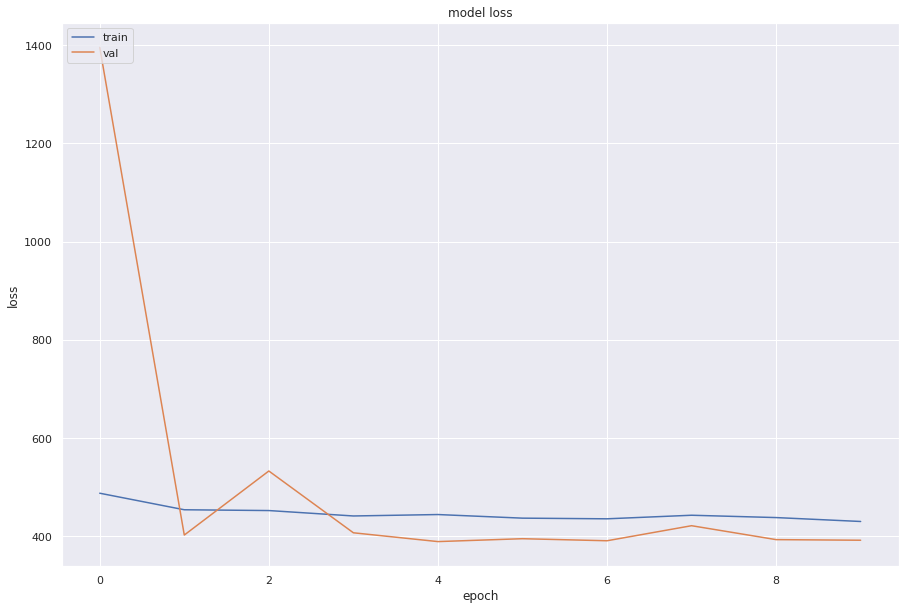

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

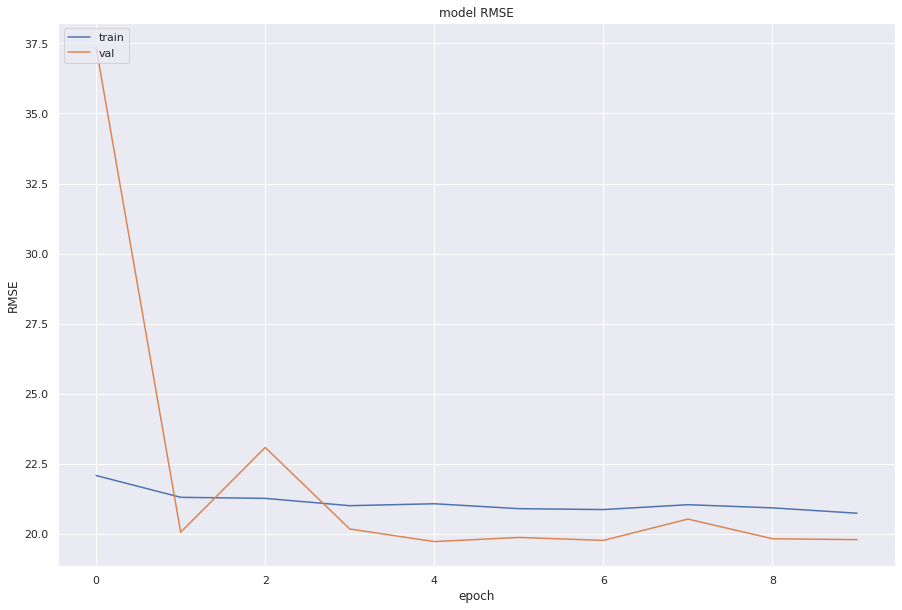

In [16]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

##### **Evaluate on the best model saved**

In [5]:
model_best = keras.models.load_model('checkpoint')

In [18]:
model_best.evaluate(test_generator)

28/28 [==============================] - 218s 8s/step - loss: 411.9700 - root_mean_squared_error: 20.2970


[411.97003173828125, 20.29704475402832]

##### **Sub model as a feature extractor**
I am using the fine-tuned model to generate features which represent images.

In [6]:
feature_model = Model(inputs=model_best.inputs, 
                      outputs=model_best.layers[-4].output)
feature_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 preprocess_1 (Preprocess)   (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 1024)              2098176   
                                                             

In [7]:
features_train = feature_model.predict(train_generator)
features_val = feature_model.predict(validation_generator)
features_test = feature_model.predict(test_generator)
np.save('features_train', features_train)
np.save('features_val', features_val)
np.save('features_test', features_test)

In [5]:
feature_train = np.load('features_train.npy')
feature_val = np.load('features_val.npy')
feature_test = np.load('features_test.npy')

In [6]:
def get_data(feature, df, image=True, meta=True):
  
  y = df['Pawpularity'].values
  X = df.drop(["Id", "image_filename", "Pawpularity"], axis=1).values
  
  if meta and not image:
    return X, y
  else:
    X = np.concatenate((feature, X), axis=1)
    return X, y

#### **Combining the Train and Validate set to do Cross-Validation on the learning set**

In [7]:
learning_meta = pd.concat([train, val], axis=0)
learning_feature = np.concatenate([feature_train, feature_val], axis=0)

#### **Linear models with and without image features:** 

I tried out Ridge Regression and Lasso Regression. The summary of different hyperparameters I tried out and their Cross-Validation RMSE and Test set RMSE are as shown. The hyperparameters were tried in a Grid search. The highlighted hyperparameter is the one which gave the best performance in the cross-validation set.

Although the test set RMSE for each setting is reported, I will only use the one which gives the lowest cross-validation RMSE.

**Ridge Regression:** Ridge Regression adds the $L_2$ penalty of the weight to the loss function. It forces many features to go close to zero.

**Lasso Regression:** Lasso Regression adds the $L_1$ penalty of the weight to the loss function. It forces many features to become zero. Thus it acts like a feature selector.

**Summary:**

|Model|With Image|Hyperparameters|Cross-Validation RMSE|Test Set RMSE|
|-----|----------|---------------|-------------------|-------------|
|Ridge|No|$\alpha$ = 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, **100**, 1000|20.6108|20.2646|
|Lasso|No|$\alpha$ = 1e-5, 1e-4, 1e-3, **1e-2**, 1e-1, 1, 10, 100, 1000|20.6112|20.2627|
|Ridge|Yes|$\alpha$ = 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, **1000** | 20.6111| 20.2549 |
|Lasso|Yes|$\alpha$ = 1e-5, 1e-4, 1e-3, 1e-2, **1e-1**, 1, 10, 100, 1000 | 20.6157 | 20.2639 |


In [8]:
# Ridge Linear model with only metadata:

from sklearn import linear_model
from sklearn.model_selection import GridSearchCV

X, y = get_data(learning_feature, learning_meta, image=False, meta=True)

parameters = {'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]}
ridge = linear_model.Ridge()
model = GridSearchCV(ridge, parameters, 
                     scoring='neg_root_mean_squared_error', verbose=3)
model.fit(X, y)

print(f"Best Score: {abs(model.best_score_)}")
print(f"Best Parameters: {model.best_params_}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END .....................alpha=1e-05;, score=-21.186 total time=   0.0s
[CV 2/5] END .....................alpha=1e-05;, score=-20.087 total time=   0.0s
[CV 3/5] END .....................alpha=1e-05;, score=-20.833 total time=   0.0s
[CV 4/5] END .....................alpha=1e-05;, score=-20.547 total time=   0.0s
[CV 5/5] END .....................alpha=1e-05;, score=-20.415 total time=   0.0s
[CV 1/5] END ....................alpha=0.0001;, score=-21.186 total time=   0.0s
[CV 2/5] END ....................alpha=0.0001;, score=-20.087 total time=   0.0s
[CV 3/5] END ....................alpha=0.0001;, score=-20.833 total time=   0.0s
[CV 4/5] END ....................alpha=0.0001;, score=-20.547 total time=   0.0s
[CV 5/5] END ....................alpha=0.0001;, score=-20.415 total time=   0.0s
[CV 1/5] END .....................alpha=0.001;, score=-21.186 total time=   0.0s
[CV 2/5] END .....................alpha=0.001;, s

In [9]:
from sklearn.metrics import mean_squared_error

X_test, y_test = get_data(feature_test, test, image=False, meta=True)
y_pred = model.best_estimator_.predict(X_test)

np.sqrt(mean_squared_error(y_pred, y_test))

20.264642112284513

In [10]:
# Lasso Linear model with only metadata:

from sklearn import linear_model
from sklearn.model_selection import GridSearchCV

X, y = get_data(learning_feature, learning_meta, image=False, meta=True)

parameters = {'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]}
lasso = linear_model.Lasso()
model = GridSearchCV(lasso, parameters, 
                     scoring='neg_root_mean_squared_error', verbose=3)
model.fit(X, y)

print(f"Best Score: {abs(model.best_score_)}")
print(f"Best Parameters: {model.best_params_}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END .....................alpha=1e-05;, score=-21.186 total time=   0.0s
[CV 2/5] END .....................alpha=1e-05;, score=-20.087 total time=   0.0s
[CV 3/5] END .....................alpha=1e-05;, score=-20.833 total time=   0.0s
[CV 4/5] END .....................alpha=1e-05;, score=-20.547 total time=   0.0s
[CV 5/5] END .....................alpha=1e-05;, score=-20.415 total time=   0.0s
[CV 1/5] END ....................alpha=0.0001;, score=-21.186 total time=   0.0s
[CV 2/5] END ....................alpha=0.0001;, score=-20.087 total time=   0.0s
[CV 3/5] END ....................alpha=0.0001;, score=-20.833 total time=   0.0s
[CV 4/5] END ....................alpha=0.0001;, score=-20.547 total time=   0.0s
[CV 5/5] END ....................alpha=0.0001;, score=-20.415 total time=   0.0s
[CV 1/5] END .....................alpha=0.001;, score=-21.186 total time=   0.0s
[CV 2/5] END .....................alpha=0.001;, s

In [11]:
from sklearn.metrics import mean_squared_error

X_test, y_test = get_data(feature_test, test, image=False, meta=True)
y_pred = model.best_estimator_.predict(X_test)

np.sqrt(mean_squared_error(y_pred, y_test))

20.262703723169857

In [13]:
# Ridge Linear model with image features and metadata:

from sklearn import linear_model
from sklearn.model_selection import GridSearchCV

X, y = get_data(learning_feature, learning_meta, image=True, meta=True)

parameters = {'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]}
ridge = linear_model.Ridge()
model = GridSearchCV(ridge, parameters, 
                     scoring='neg_root_mean_squared_error', verbose=3)
model.fit(X, y)

print(f"Best Score: {abs(model.best_score_)}")
print(f"Best Parameters: {model.best_params_}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END .....................alpha=1e-05;, score=-22.332 total time=   0.3s
[CV 2/5] END .....................alpha=1e-05;, score=-20.701 total time=   0.3s
[CV 3/5] END .....................alpha=1e-05;, score=-23.165 total time=   0.3s
[CV 4/5] END .....................alpha=1e-05;, score=-23.022 total time=   0.3s
[CV 5/5] END .....................alpha=1e-05;, score=-21.495 total time=   0.3s
[CV 1/5] END ....................alpha=0.0001;, score=-21.660 total time=   0.3s
[CV 2/5] END ....................alpha=0.0001;, score=-20.512 total time=   0.3s
[CV 3/5] END ....................alpha=0.0001;, score=-21.760 total time=   0.3s
[CV 4/5] END ....................alpha=0.0001;, score=-21.607 total time=   0.3s
[CV 5/5] END ....................alpha=0.0001;, score=-20.861 total time=   0.3s
[CV 1/5] END .....................alpha=0.001;, score=-21.416 total time=   0.3s
[CV 2/5] END .....................alpha=0.001;, s

In [ ]:
from sklearn.metrics import mean_squared_error

X_test, y_test = get_data(feature_test, test, image=True, meta=True)
y_pred = model.best_estimator_.predict(X_test)

np.sqrt(mean_squared_error(y_pred, y_test))

20.254958750354422

In [14]:
# Lasso Linear model with image feature and metadata:

import warnings
warnings.filterwarnings('ignore')

from sklearn import linear_model
from sklearn.model_selection import GridSearchCV

X, y = get_data(learning_feature, learning_meta, image=True, meta=True)

parameters = {'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]}
lasso = linear_model.Lasso()
model = GridSearchCV(lasso, parameters, 
                     scoring='neg_root_mean_squared_error', verbose=3)
model.fit(X, y)

print(f"Best Score: {abs(model.best_score_)}")
print(f"Best Parameters: {model.best_params_}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END .....................alpha=1e-05;, score=-21.462 total time=   1.7s
[CV 2/5] END .....................alpha=1e-05;, score=-20.439 total time=   1.7s
[CV 3/5] END .....................alpha=1e-05;, score=-21.246 total time=   1.7s
[CV 4/5] END .....................alpha=1e-05;, score=-21.369 total time=   1.6s
[CV 5/5] END .....................alpha=1e-05;, score=-20.810 total time=   1.7s
[CV 1/5] END ....................alpha=0.0001;, score=-21.292 total time=   1.6s
[CV 2/5] END ....................alpha=0.0001;, score=-20.337 total time=   1.6s
[CV 3/5] END ....................alpha=0.0001;, score=-21.044 total time=   1.6s
[CV 4/5] END ....................alpha=0.0001;, score=-20.799 total time=   1.6s
[CV 5/5] END ....................alpha=0.0001;, score=-20.676 total time=   1.6s
[CV 1/5] END .....................alpha=0.001;, score=-21.233 total time=   1.4s
[CV 2/5] END .....................alpha=0.001;, s

In [15]:
from sklearn.metrics import mean_squared_error

X_test, y_test = get_data(feature_test, test, image=True, meta=True)
y_pred = model.best_estimator_.predict(X_test)

np.sqrt(mean_squared_error(y_pred, y_test))

20.263943781744853

#### **Ensemble models with and without image features:**

I tried out three different ensemble models - Random Forest, Adaboost, and Stacking. The details of the hyperparameters and their cross-validated RMSE is shown in the summary below. I have reported the test set RMSE of all the settings. However, I will use the model which has the lowest cross-validation RMSE. 

**Random Forest:** This model uses decision trees as the base estimator. Each tree is trained in parallel and makes an estimate. The estimation is combined by average to come up with the final estimation.

**Adaboost:** This model uses decision trees as the base estimators. The tress are trained sequentially with an aim to minimize the error made by the previous tree. The trees are combined to come up with a prediction.

**Stacking:** For stacking I used base estimators as Ridge Regressor, Support Vector Regressor, Random Forest Regressor which were combined using Linear Regressor. the hyperparameters of the base estimator is the one which showed best performance in their respective segment. Since I didn't tried Support Vector Regressor, I selected default hyperparameter for it.

**Summary:**

|Model|With Image|Hyperparameters|Cross-Validation RMSE|Test Set RMSE|
|-----|----------|---------------|-------------------|-------------|
|Random Forest|No|n_estimators = 10, **100**, 200; max_features = **sqrt**, log2; min_samples_split = 2, **5**|20.7920|20.4612|
|Random Forest|Yes|n_estimators = 10, **100**, 200; max_features = sqrt, **log2**; min_samples_split = 2, **5**|20.9445|20.5024|
|Adaboost|No|n_estimators = 10, 20, 50, **100**; learning_rate = **1e-5**, 1e-3, 1e-1, 1, 10 | 20.6069| 20.2755|
|Adaboost|Yes|n_estimators = 10, 20, 50, **100**; learning_rate = **1e-5**, 1e-3, 1e-1, 1, 10 | 20.6085| 20.2390|

\


|Model|With Image|Base Estimators|Final Estimators| Test Set RMSE|
|-----|----------|---------------|----------------|--------------|
|Stacking|No| Ridge Regressor, Support Vector Regressor, Random Forest Regressor| Linear Regressor | 20.2350|
|Stacking|Yes| Ridge Regressor, Support Vector Regressor, Random Forest Regressor| Linear Regressor| 20.2282|

In [17]:
# Random Forest Ensemble with only metadata:

from sklearn import ensemble
from sklearn.model_selection import GridSearchCV

X, y = get_data(learning_feature, learning_meta, image=False, meta=True)

parameters = {'n_estimators': [10, 100, 200],
              'max_features': ["sqrt", "log2"],
              'min_samples_split': [2, 5]}
rf = ensemble.RandomForestRegressor()
model = GridSearchCV(rf, parameters, 
                     scoring='neg_root_mean_squared_error', verbose=3)
model.fit(X, y)

print(f"Best Score: {abs(model.best_score_)}")
print(f"Best Parameters: {model.best_params_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END max_features=sqrt, min_samples_split=2, n_estimators=10;, score=-21.438 total time=   0.0s
[CV 2/5] END max_features=sqrt, min_samples_split=2, n_estimators=10;, score=-20.268 total time=   0.0s
[CV 3/5] END max_features=sqrt, min_samples_split=2, n_estimators=10;, score=-21.160 total time=   0.0s
[CV 4/5] END max_features=sqrt, min_samples_split=2, n_estimators=10;, score=-20.871 total time=   0.0s
[CV 5/5] END max_features=sqrt, min_samples_split=2, n_estimators=10;, score=-20.591 total time=   0.0s
[CV 1/5] END max_features=sqrt, min_samples_split=2, n_estimators=100;, score=-21.469 total time=   0.3s
[CV 2/5] END max_features=sqrt, min_samples_split=2, n_estimators=100;, score=-20.271 total time=   0.2s
[CV 3/5] END max_features=sqrt, min_samples_split=2, n_estimators=100;, score=-21.157 total time=   0.3s
[CV 4/5] END max_features=sqrt, min_samples_split=2, n_estimators=100;, score=-20.780 total time=   0.2s

In [18]:
from sklearn.metrics import mean_squared_error

X_test, y_test = get_data(feature_test, test, image=False, meta=True)
y_pred = model.best_estimator_.predict(X_test)

np.sqrt(mean_squared_error(y_pred, y_test))

20.461297707177685

In [19]:
# Random Forest Ensemble with images and metadata:

from sklearn import ensemble
from sklearn.model_selection import GridSearchCV

X, y = get_data(learning_feature, learning_meta, image=True, meta=True)

parameters = {'n_estimators': [10, 100, 200],
              'max_features': ["sqrt", "log2"],
              'min_samples_split': [2, 5]}
rf = ensemble.RandomForestRegressor()
model = GridSearchCV(rf, parameters, 
                     scoring='neg_root_mean_squared_error', verbose=3)
model.fit(X, y)

print(f"Best Score: {abs(model.best_score_)}")
print(f"Best Parameters: {model.best_params_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END max_features=sqrt, min_samples_split=2, n_estimators=10;, score=-22.440 total time=   0.6s
[CV 2/5] END max_features=sqrt, min_samples_split=2, n_estimators=10;, score=-21.174 total time=   0.6s
[CV 3/5] END max_features=sqrt, min_samples_split=2, n_estimators=10;, score=-22.252 total time=   0.6s
[CV 4/5] END max_features=sqrt, min_samples_split=2, n_estimators=10;, score=-21.862 total time=   0.6s
[CV 5/5] END max_features=sqrt, min_samples_split=2, n_estimators=10;, score=-21.838 total time=   0.6s
[CV 1/5] END max_features=sqrt, min_samples_split=2, n_estimators=100;, score=-21.492 total time=   5.8s
[CV 2/5] END max_features=sqrt, min_samples_split=2, n_estimators=100;, score=-20.400 total time=   5.7s
[CV 3/5] END max_features=sqrt, min_samples_split=2, n_estimators=100;, score=-21.239 total time=   5.8s
[CV 4/5] END max_features=sqrt, min_samples_split=2, n_estimators=100;, score=-20.935 total time=   5.8s

In [20]:
from sklearn.metrics import mean_squared_error

X_test, y_test = get_data(feature_test, test, image=True, meta=True)
y_pred = model.best_estimator_.predict(X_test)

np.sqrt(mean_squared_error(y_pred, y_test))

20.502402966471422

In [21]:
# Adaboost Ensemble with only metadata:

from sklearn import ensemble
from sklearn.model_selection import GridSearchCV

X, y = get_data(learning_feature, learning_meta, image=False, meta=True)

parameters = {'n_estimators': [10, 20, 50, 100],
              'learning_rate': [1e-5, 1e-3, 1e-1, 1, 10]}
ab = ensemble.AdaBoostRegressor()
model = GridSearchCV(ab, parameters, 
                     scoring='neg_root_mean_squared_error', verbose=3)
model.fit(X, y)

print(f"Best Score: {abs(model.best_score_)}")
print(f"Best Parameters: {model.best_params_}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END learning_rate=1e-05, n_estimators=10;, score=-21.187 total time=   0.1s
[CV 2/5] END learning_rate=1e-05, n_estimators=10;, score=-20.069 total time=   0.1s
[CV 3/5] END learning_rate=1e-05, n_estimators=10;, score=-20.799 total time=   0.0s
[CV 4/5] END learning_rate=1e-05, n_estimators=10;, score=-20.562 total time=   0.1s
[CV 5/5] END learning_rate=1e-05, n_estimators=10;, score=-20.423 total time=   0.0s
[CV 1/5] END learning_rate=1e-05, n_estimators=20;, score=-21.207 total time=   0.1s
[CV 2/5] END learning_rate=1e-05, n_estimators=20;, score=-20.077 total time=   0.1s
[CV 3/5] END learning_rate=1e-05, n_estimators=20;, score=-20.818 total time=   0.1s
[CV 4/5] END learning_rate=1e-05, n_estimators=20;, score=-20.567 total time=   0.1s
[CV 5/5] END learning_rate=1e-05, n_estimators=20;, score=-20.397 total time=   0.1s
[CV 1/5] END learning_rate=1e-05, n_estimators=50;, score=-21.184 total time=   0.2s
[CV

In [22]:
from sklearn.metrics import mean_squared_error

X_test, y_test = get_data(feature_test, test, image=False, meta=True)
y_pred = model.best_estimator_.predict(X_test)

np.sqrt(mean_squared_error(y_pred, y_test))

20.275556622767706

In [23]:
# Adaboost Ensemble with images and metadata:

from sklearn import ensemble
from sklearn.model_selection import GridSearchCV

X, y = get_data(learning_feature, learning_meta, image=True, meta=True)

parameters = {'n_estimators': [10, 20, 50, 100],
              'learning_rate': [1e-5, 1e-3, 1e-1, 1, 10]}
ab = ensemble.AdaBoostRegressor()
model = GridSearchCV(ab, parameters, 
                     scoring='neg_root_mean_squared_error', verbose=3)
model.fit(X, y)

print(f"Best Score: {abs(model.best_score_)}")
print(f"Best Parameters: {model.best_params_}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END learning_rate=1e-05, n_estimators=10;, score=-21.201 total time=   4.2s
[CV 2/5] END learning_rate=1e-05, n_estimators=10;, score=-20.088 total time=   4.2s
[CV 3/5] END learning_rate=1e-05, n_estimators=10;, score=-20.799 total time=   4.2s
[CV 4/5] END learning_rate=1e-05, n_estimators=10;, score=-20.576 total time=   4.2s
[CV 5/5] END learning_rate=1e-05, n_estimators=10;, score=-20.409 total time=   4.2s
[CV 1/5] END learning_rate=1e-05, n_estimators=20;, score=-21.188 total time=   8.4s
[CV 2/5] END learning_rate=1e-05, n_estimators=20;, score=-20.076 total time=   8.3s
[CV 3/5] END learning_rate=1e-05, n_estimators=20;, score=-20.811 total time=   8.3s
[CV 4/5] END learning_rate=1e-05, n_estimators=20;, score=-20.557 total time=   8.3s
[CV 5/5] END learning_rate=1e-05, n_estimators=20;, score=-20.426 total time=   8.5s
[CV 1/5] END learning_rate=1e-05, n_estimators=50;, score=-21.182 total time=  20.8s
[CV

In [24]:
from sklearn.metrics import mean_squared_error

X_test, y_test = get_data(feature_test, test, image=True, meta=True)
y_pred = model.best_estimator_.predict(X_test)

np.sqrt(mean_squared_error(y_pred, y_test))

20.2390051515127

In [25]:
# Stacking Ensemble with only metadata:

from sklearn.linear_model import Ridge, LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor

X, y = get_data(learning_feature, learning_meta, image=False, meta=True)

estimators = [
    ('ridge', Ridge(alpha=100)),
    ('svr', SVR()),
    ('rfr', RandomForestRegressor(n_estimators=100, max_features='sqrt', 
                                  min_samples_split=5))
]

model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)

model.fit(X, y)

StackingRegressor(estimators=[('ridge', Ridge(alpha=100)), ('svr', SVR()),
                              ('rfr',
                               RandomForestRegressor(max_features='sqrt',
                                                     min_samples_split=5))],
                  final_estimator=LinearRegression())

In [26]:
from sklearn.metrics import mean_squared_error

X_test, y_test = get_data(feature_test, test, image=False, meta=True)
y_pred = model.predict(X_test)

np.sqrt(mean_squared_error(y_pred, y_test))

20.235017347630762

In [27]:
# Stacking Ensemble with images and metadata:

from sklearn.linear_model import Ridge, LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor

X, y = get_data(learning_feature, learning_meta, image=True, meta=True)

estimators = [
    ('ridge', Ridge(alpha=1000)),
    ('svr', SVR()),
    ('rfr', RandomForestRegressor(max_features='log2', min_samples_split=5, 
                                  n_estimators=100))
]

model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)

model.fit(X, y)

StackingRegressor(estimators=[('ridge', Ridge(alpha=1000)), ('svr', SVR()),
                              ('rfr',
                               RandomForestRegressor(max_features='log2',
                                                     min_samples_split=5))],
                  final_estimator=LinearRegression())

In [28]:
from sklearn.metrics import mean_squared_error

X_test, y_test = get_data(feature_test, test, image=True, meta=True)
y_pred = model.predict(X_test)

np.sqrt(mean_squared_error(y_pred, y_test))

20.228251830177204